# Data Cleaning

## Set up Environment

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nilearn import plotting, datasets, image
from nilearn.datasets import fetch_atlas_aal, load_mni152_template
import nibabel as nib
from matplotlib.ticker import FormatStrFormatter

# Make sure you can see all output
pd.options.display.max_rows = 4000

In [13]:
# Store filepath in a variable
dfMRI = pd.read_csv("QuantsData/A0_Baseline/sub-dPPA09_ses-HAMILTONA1BAS_aalquants.csv") #Note, this is just the dataset for dPPA-09

## Set up MRI dataset and visualize

In [4]:
# Check dPPA-09 MRI Data
dfMRI.head()

,PID,Session_ID,system,label,name,measure,metric,value
0,9,0,aal116,2001,Precentral_L,volume,numeric,8410.6244
1,9,0,aal116,2002,Precentral_R,volume,numeric,8332.8004
2,9,0,aal116,2101,Frontal_Sup_L,volume,numeric,7399.4243
3,9,0,aal116,2102,Frontal_Sup_R,volume,numeric,7978.4964
4,9,0,aal116,2111,Frontal_Sup_Orb_L,volume,numeric,2465.7921


### Cortical Thickness Data

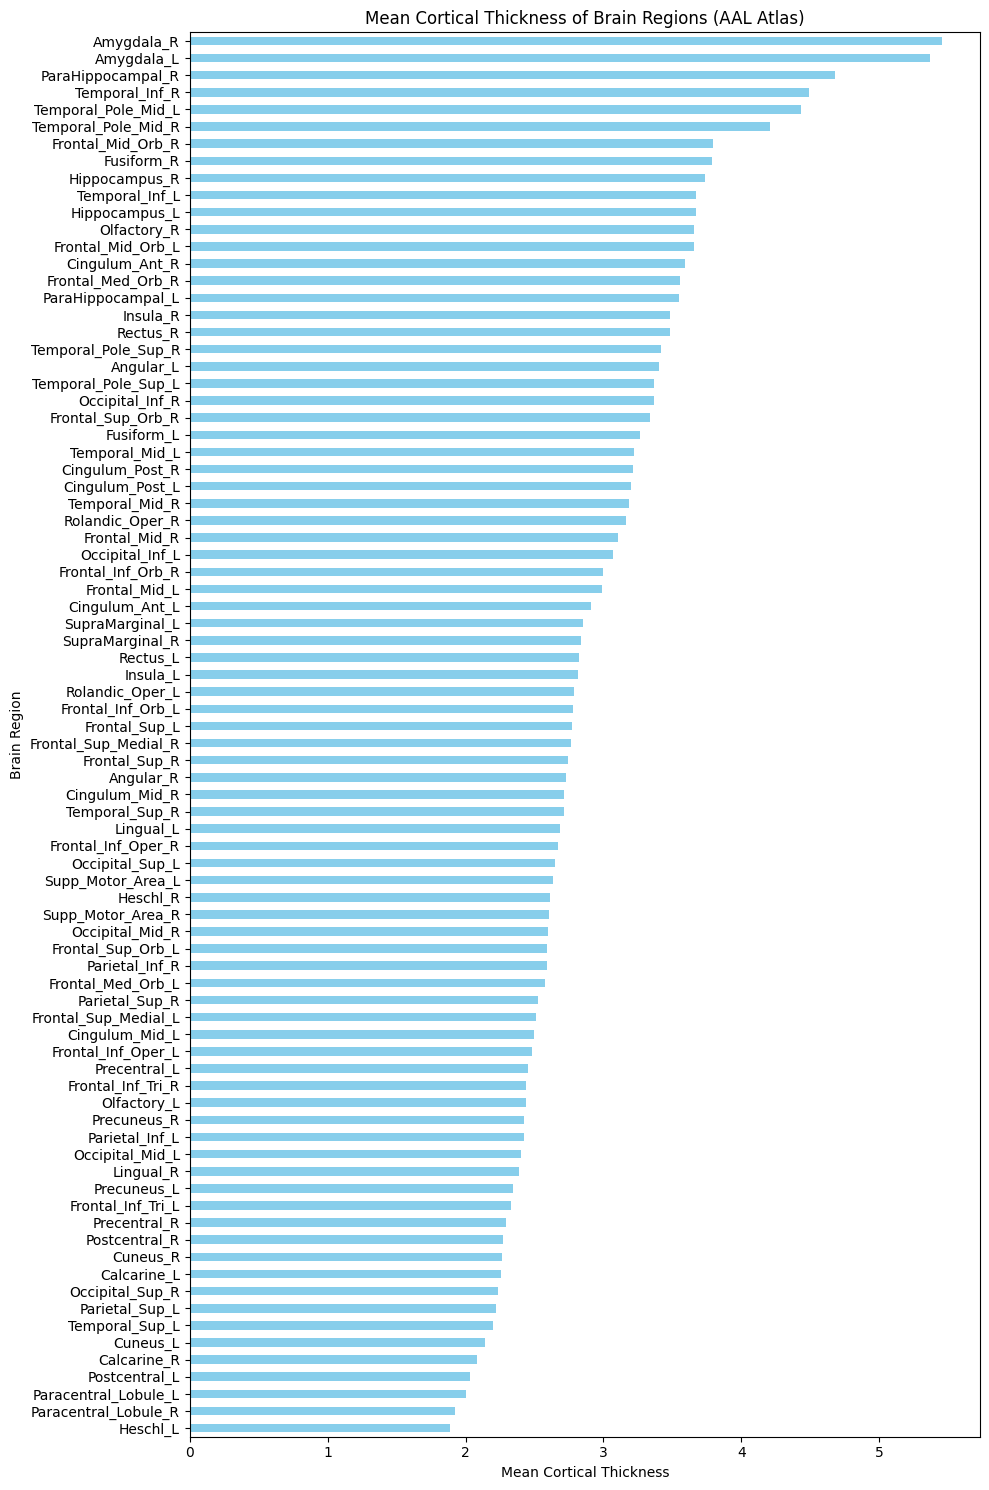

In [14]:
# Filter for mean cortical thickness using the AAL system
thickness_data = dfMRI[(dfMRI['measure'] == 'thickness') & (dfMRI['metric'] == 'mean') & (dfMRI['system'] == 'aal116')]

# Group by region and calculate mean thickness for each region
grouped_data = thickness_data.groupby('name')['value'].mean().sort_values()

# Plotting
plt.figure(figsize=(10, 15))
grouped_data.plot(kind='barh', color='skyblue')
plt.xlabel('Mean Cortical Thickness')
plt.ylabel('Brain Region')
plt.title('Mean Cortical Thickness of Brain Regions (AAL Atlas)')
plt.tight_layout()
plt.show()


### Volume Data

In [18]:
# Filter for volume data using the AAL system
volume_data = dfMRI[(dfMRI['measure'] == 'volume') & (dfMRI['system'] == 'aal116')]
volume_data.head()

,PID,Session_ID,system,label,name,measure,metric,value
0,9,0,aal116,2001,Precentral_L,volume,numeric,8410.6244
1,9,0,aal116,2002,Precentral_R,volume,numeric,8332.8004
2,9,0,aal116,2101,Frontal_Sup_L,volume,numeric,7399.4243
3,9,0,aal116,2102,Frontal_Sup_R,volume,numeric,7978.4964
4,9,0,aal116,2111,Frontal_Sup_Orb_L,volume,numeric,2465.7921


In [20]:
# Load the AAL atlas
aal_atlas = datasets.fetch_atlas_aal(version='SPM12', data_dir=None, url=None, resume=True, verbose=1)
aal_maps = nib.load(aal_atlas.maps)  # Load the atlas using nibabel
aal_labels = aal_atlas.labels

In [26]:
# Prepare volume data for mapping
# Initialize a numpy array with a length equal to the number of regions
num_regions = len(aal_labels)  # Number of regions in the atlas
volumes = np.zeros(num_regions)

# Create a dictionary to map AAL atlas labels to indices
label_to_index = {label: index for index, label in enumerate(aal_labels)}

# Map the volume data to the corresponding regions in the AAL atlas
for index, row in volume_data.iterrows():
    region_name = row['name']
    if region_name in label_to_index:
        region_index = label_to_index[region_name]
        volumes[region_index] = row['value']


In [28]:
# To map the regional volumes to the full brain, we create a new brain map
# where each voxel's value corresponds to the volume of the region it belongs to
brain_map = np.copy(aal_maps.get_fdata())
for region_idx, volume in enumerate(volumes):
    brain_map[brain_map == region_idx + 1] = volume

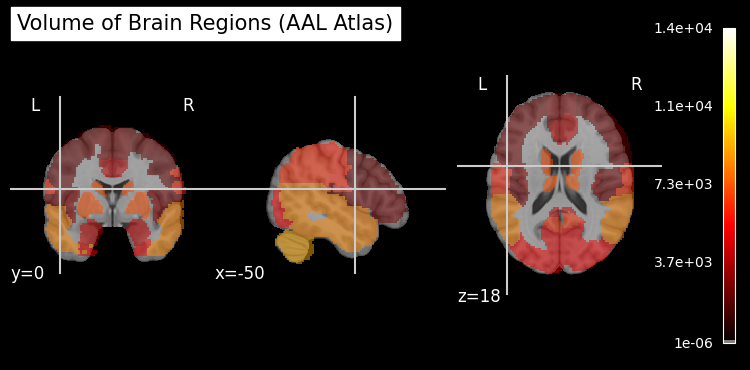

In [73]:
# Load MNI152 template
mni152_template = load_mni152_template()

# Plotting
plotting.plot_stat_map(
    nib.Nifti1Image(brain_map, aal_maps.affine),
    bg_img=mni152_template,
    display_mode='ortho',
    title='Volume of Brain Regions (AAL Atlas)',
    cut_coords=(-50, 0, 18),
    colorbar=True,
    cmap='hot',
    alpha=0.5,
    vmax=volumes.max(),
    vmin=volumes.min()
) 

plotting.show()